# Auto Encoder

## Import

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm, trange
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
import requests
from bs4 import BeautifulSoup
import bottleneck as bn

## Config

In [2]:
cfg = {
    "K": 1024,
    "lr" : 1e-4,
    "n_epochs" : 500,
    "data_dir" : "./dataset",
    "data_file" : "user_problem_mat.csv",
    "batch_size" : 64,
    "test_batch_size" : 32,
    "topks" : [10,20,50,100],
}
cfg["model_path"] = f"./saved_model/auto_encoder_model.pt"
cfg["device"] = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f'Using {cfg["device"]} device')

Using cuda device


## Utils

In [3]:
#########################################
################# Test ##################
#########################################

def getLabel(test_data, pred_data):
    r = []
    for i in range(len(test_data)):
        groundTrue = test_data[i]
        predictTopK = pred_data[i]
        pred = list(map(lambda x: x in groundTrue, predictTopK))
        pred = np.array(pred).astype("float")
        r.append(pred)
    return np.array(r).astype('float')

def NDCGatK_r(test_data,r,k):
    """
    Normalized Discounted Cumulative Gain
    rel_i = 1 or 0, so 2^{rel_i} - 1 = 1 or 0
    """
    assert len(r) == len(test_data)
    pred_data = r[:, :k]

    test_matrix = np.zeros((len(pred_data), k))
    for i, items in enumerate(test_data):
        length = k if k <= len(items) else len(items)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = np.sum(max_r * 1./np.log2(np.arange(2, k + 2)), axis=1)
    dcg = pred_data*(1./np.log2(np.arange(2, k + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg/idcg
    ndcg[np.isnan(ndcg)] = 0.
    return np.sum(ndcg)

def RecallPrecision_ATk(test_data, r, k):
    """
    test_data should be a list? cause users may have different amount of pos items. shape (test_batch, k)
    pred_data : shape (test_batch, k) NOTE: pred_data should be pre-sorted
    k : top-k
    """
    right_pred = r[:, :k].sum(1)
    precis_n = k
    recall_n = np.array([len(test_data[i]) for i in range(len(test_data))])
    recall = np.sum(right_pred/recall_n)
    precis = np.sum(right_pred)/precis_n
    return {'recall': recall, 'precision': precis}

def test_one_batch(X, cfg):
    sorted_items = X[0].numpy()
    groundTrue = X[1]
    r = getLabel(groundTrue, sorted_items)
    pre, recall, ndcg = [], [], []
    for k in cfg['topks']:
        ret = RecallPrecision_ATk(groundTrue, r, k)
        pre.append(ret['precision'])
        recall.append(ret['recall'])
        ndcg.append(NDCGatK_r(groundTrue,r,k))
    return {'recall':np.array(recall), 
            'precision':np.array(pre), 
            'ndcg':np.array(ndcg)}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36'}    
    
def add_to_user_problem_mat(idx, id, user_problem_mat : np.array):
    data = requests.get(f'https://www.acmicpc.net/user/{id}', headers=headers)
    soup = BeautifulSoup(data.text, 'html.parser')
    trs = soup.select('div.problem-list')

    for tr in trs:
        problem_nums = tr.select('a')
            
        for problem_num in problem_nums :

            problem_num = int(problem_num.text) - 1000
            #print(problem_num)
            try:
                user_problem_mat[idx,problem_num] = 1
            except:
                print("범위를 벗어난 문제 번호 : " + str(problem_num))


## Model

In [4]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        
    def getUsersRating(self, user_row):
        raise NotImplementedError

class AutoEncoder(BaseModel):
    
    def __init__(self, item_n, cfg):
        """
        Arguments
        - sparse_matrix : user-item rating matrix
        - cfg : configuration dict
            - K (int)       : number of latent dimensions
            - device : using device
        """
        super(AutoEncoder, self).__init__()
        # convert ndArray
        self.item_n = item_n
        self.K = cfg["K"]
        self.device = cfg["device"]
        
        # Initialize user and item latent feature matrice
        self.I_1 = nn.Linear(self.item_n, self.K, bias=True, device = self.device)
        self.I_2 = nn.Linear(self.K, self.item_n, bias=True, device = self.device)

        nn.init.normal_(self.I_1.weight, std=1./self.K)
        nn.init.normal_(self.I_2.weight, std=1./self.K)

    def forward(self, x):
        user_emb = self.I_1(x)
        rating = self.I_2(user_emb)
 
        return rating        

    def getUsersRating(self, user_row : np.array):
        return self.forward(torch.Tensor(user_row).cuda()).cpu().detach().numpy()

class EASE():
    """
    Embarrassingly Shallow Autoencoders model class
    """

    def __init__(self, lambda_):
        self.B = None
        self.lambda_ = lambda_

    def train(self, interaction_matrix):
        """
        train pass
        :param interaction_matrix: interaction_matrix
        """
        G = interaction_matrix.T @ interaction_matrix
        diag = list(range(G.shape[0]))
        G[diag, diag] += self.lambda_
        P = np.linalg.inv(G)

        # B = P * (X^T * X − diagMat(γ))
        self.B = P / -np.diag(P)
        min_dim = min(*self.B.shape)
        self.B[range(min_dim), range(min_dim)] = 0

    def forward(self, user_row):
        """
        forward pass
        """
        return user_row @ self.B
    
    def getUsersRating(self, user_row : np.array):
        return self.forward(user_row)

## DataSet

In [5]:
# Dataset 상속
class AEDataset(Dataset): 
    def __init__(self, sparse_matrix, test=False):
        if type(sparse_matrix) != np.array : sparse_matrix = pd.DataFrame(sparse_matrix)
        
        self.sparse_matrix = sparse_matrix.fillna(0).to_numpy()
        
        if test:
            self.maxK = max(cfg['topks'])
            test_data = []
            
            for user in range(len(self.sparse_matrix)):      
                items = self.sparse_matrix[user].nonzero()[0]
                if len(items) >= self.maxK :
                    test_data.append(self.sparse_matrix[user])  
                    
            self.sparse_matrix = np.array(test_data)    
            print("complete making test dict")      

    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.sparse_matrix)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.sparse_matrix[idx]).cuda()
        return x

In [6]:
train_data_path = f'{cfg["data_dir"]}/train_{cfg["data_file"]}'
train_s_mat = pd.read_csv(train_data_path, index_col = 0)

test_data_path = f'{cfg["data_dir"]}/test_{cfg["data_file"]}'
test_s_mat = pd.read_csv(test_data_path, index_col = 0)

In [7]:
train_dataset = AEDataset(train_s_mat)
test_dataset = AEDataset(test_s_mat, test=True)

complete making test dict


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=cfg["batch_size"])
test_dataloader = DataLoader(test_dataset, batch_size=cfg["test_batch_size"])

## Train & Test

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, X in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss

def make_test_list(data):
    test_list = []
    for d in data:
        test_list.append(d.nonzero().squeeze(1))
    return test_list

def test_loop(dataloader, model, cfg, loss_fn=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    max_K = max(cfg['topks'])
    
    results = {'precision': np.zeros(len(cfg['topks'])),
               'recall': np.zeros(len(cfg['topks'])),
               'ndcg': np.zeros(len(cfg['topks'])),
               'test_loss' : 0}

    if num_batches != 0 and num_batches < size :
        with torch.no_grad():
            try:
                assert num_batches <= size / 10
            except AssertionError:
                print(f"test_u_batch_size is too big for this dataset, try a small one {size // 10}")
            rating_list = []
            groundTrue_list = []        
            for X in dataloader:
                rating = model(X)
                _, rating_K = torch.topk(rating, k=max_K) # rating_K는 rating에서 k번째 높은 rating까지의 index

                rating_list.append(rating_K.cpu())
                gt = make_test_list(X)
                groundTrue_list.append(gt)

                if loss_fn is not None:
                    results['test_loss'] += loss_fn(rating, X).item()
                del rating

            X = zip(rating_list, groundTrue_list)
            pre_results = []
            for x in X:
                pre_results.append(test_one_batch(x,cfg))
            for result in pre_results:
                results['recall'] += result['recall']
                results['precision'] += result['precision']
                results['ndcg'] += result['ndcg']
            results['recall'] /= float(size)
            results['precision'] /= float(size)
            results['ndcg'] /= float(size)

        results['test_loss'] /= num_batches
    return results
    
def test_loop_np(dataloader, model, cfg, loss_fn=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    max_K = max(cfg['topks'])
    
    results = {'precision': np.zeros(len(cfg['topks'])),
               'recall': np.zeros(len(cfg['topks'])),
               'ndcg': np.zeros(len(cfg['topks'])),
               'test_loss' : 0}

    if num_batches != 0 and num_batches < size : 
        try:
            assert num_batches <= size / 10
        except AssertionError:
            print(f"test_u_batch_size is too big for this dataset, try a small one {size // 10}")
        rating_list = []
        groundTrue_list = []        
        for X in dataloader:
            rating = torch.tensor(model.getUsersRating(X.cpu().numpy())).cuda()
            _, rating_K = torch.topk(rating, k=max_K) # rating_K는 rating에서 k번째 높은 rating까지의 index

            rating_list.append(rating_K.cpu())
            gt = make_test_list(X)
            groundTrue_list.append(gt)

            if loss_fn is not None:
                results['test_loss'] += loss_fn(rating, X).item()
            del rating

        X = zip(rating_list, groundTrue_list)
        pre_results = []
        for x in X:
            pre_results.append(test_one_batch(x,cfg))
        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(size)
        results['precision'] /= float(size)
        results['ndcg'] /= float(size)
        results['test_loss'] /= num_batches
    return results

def save_result_to_tensor_board(result, epoch, div="Test"):
    for i, k in enumerate(cfg["topks"]):
        writer.add_scalar(f"[{div}]/Precision_@{k}", result['precision'][i], epoch)
        writer.add_scalar(f"[{div}]/Recall_@{k}", result['recall'][i], epoch)
        writer.add_scalar(f"[{div}]/ndcg_@{k}", result['ndcg'][i], epoch)

In [10]:
RecModel = AutoEncoder(train_s_mat.shape[1], cfg)
optim = torch.optim.Adam(RecModel.parameters(), lr=cfg["lr"], betas=(0.9, 0.999), weight_decay=1e-6)
loss_fn = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
#torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

In [239]:
max_recall = 0

In [240]:
writer = SummaryWriter()
st_num = 0

for i in range(st_num,cfg["n_epochs"]+st_num):
    if i % 20 == 0:
        train_res = test_loop(train_dataloader, RecModel, cfg, loss_fn)
        test_res = test_loop(test_dataloader, RecModel, cfg, loss_fn)
        save_result_to_tensor_board(train_res, i, div="Train")
        save_result_to_tensor_board(test_res, i)    
        writer.add_scalar(f"Loss/test", test_res['test_loss'], i)
        print("TEST [train_data]")
        print(train_res)
        print("TEST [test_data]")
        print(test_res)
        print("==========================")
        if max_recall < max(test_res["recall"]) :
            max_recall = max(test_res["recall"])
            torch.save(RecModel.state_dict(), cfg["model_path"])
    loss = train_loop(train_dataloader, RecModel, loss_fn, optim)  
    writer.add_scalar(f"Loss/train", loss, i)
    if i % 5 == 0:
        print(f"loss: {loss:>7f}  [{i:>5d}/{cfg['n_epochs']+st_num:>5d}]")
            
writer.flush()
writer.close()

TEST [train_data]
{'precision': array([0.00417143, 0.00405714, 0.00426286, 0.00545714]), 'recall': array([0.00014064, 0.00027028, 0.00069549, 0.00175348]), 'ndcg': array([0.00395303, 0.00393439, 0.00414827, 0.00511296]), 'test_loss': 0.010870212841440331}
TEST [test_data]
{'precision': array([0.00453333, 0.00366667, 0.00437333, 0.00532   ]), 'recall': array([0.00015044, 0.00024111, 0.00070448, 0.00177643]), 'ndcg': array([0.00429021, 0.00373487, 0.00422753, 0.00501043]), 'test_loss': 0.010464023620365782}
loss: 0.007082  [    0/  500]
loss: 0.005522  [    5/  500]
loss: 0.004476  [   10/  500]
loss: 0.003583  [   15/  500]
TEST [train_data]
{'precision': array([0.99845714, 0.99685714, 0.99113143, 0.97121143]), 'recall': array([0.03938244, 0.07861227, 0.19514111, 0.38068008]), 'ndcg': array([0.99878006, 0.99755435, 0.99306297, 0.97733818]), 'test_loss': 0.003034477871419354}
TEST [test_data]
{'precision': array([0.9936    , 0.9912    , 0.97976   , 0.94942667]), 'recall': array([0.040345

loss: 0.000238  [  260/  500]
loss: 0.000226  [  265/  500]
loss: 0.000224  [  270/  500]
loss: 0.000225  [  275/  500]
TEST [train_data]
{'precision': array([1., 1., 1., 1.]), 'recall': array([0.03945172, 0.07890343, 0.19725858, 0.39451717]), 'ndcg': array([1., 1., 1., 1.]), 'test_loss': 0.0003778457943223078}
TEST [test_data]
{'precision': array([1.        , 1.        , 1.        , 0.99981333]), 'recall': array([0.04062342, 0.08124685, 0.20311712, 0.40613336]), 'ndcg': array([1.        , 1.        , 1.        , 0.99986059]), 'test_loss': 0.0018347507278296225}
loss: 0.000228  [  280/  500]
loss: 0.000224  [  285/  500]
loss: 0.000223  [  290/  500]
loss: 0.000223  [  295/  500]
TEST [train_data]
{'precision': array([1., 1., 1., 1.]), 'recall': array([0.03945172, 0.07890343, 0.19725858, 0.39451717]), 'ndcg': array([1., 1., 1., 1.]), 'test_loss': 0.00037137606149454684}
TEST [test_data]
{'precision': array([1.        , 1.        , 1.        , 0.99981333]), 'recall': array([0.04062342, 

In [13]:
# 모델 불러오기
RecModel = AutoEncoder(num_problem, cfg)
RecModel.load_state_dict(torch.load(cfg["model_path"]))
test_loop(test_dataloader, RecModel, cfg, loss_fn)

{'precision': array([1.        , 1.        , 1.        , 0.99985333]),
 'recall': array([0.04062342, 0.08124685, 0.20311712, 0.4061518 ]),
 'ndcg': array([1.        , 1.        , 1.        , 0.99989041]),
 'test_loss': 0.001781787781510502}

# TEST

In [7]:
import random
def random_sample(num_col, num_row, min_ratio=0.01, max_ratio=0.02):
    test_s_mat_rand = np.zeros((num_col,num_row))

    for i in range(num_col):
        min_num = int(num_row * min_ratio)
        max_num = int(num_row * max_ratio)
        num_sample = random.sample(range(min_num,max_num),1)[0]

        num_list = random.sample(range(num_row),num_sample)
        
        test_s_mat_rand[i][num_list] = 1
    
    return test_s_mat_rand

def print_sparcity(mat):
    if type(mat) != np.array : mat = np.array(mat)
    
    len_zeros = len(np.where(mat == 0)[0])
    len_ones = len(np.where(mat != 0)[0])
    sparcity = len_zeros / (len_zeros + len_ones)
    print(f"0 개수 : {len_zeros}")
    print(f"1 개수 : {len_ones}")
    print(f"sparsity : {sparcity}")
    
def print_result(res):
    print(f'precision : {res["precision"]}')
    print(f'recall : {res["recall"]}')
    print(f'ndcg : {res["ndcg"]}')
    print(f'test_loss : {res["test_loss"]}')

In [11]:
# 모델 불러오기
st_pb_num = 1000
ed_pb_num = 27981
num_problem = ed_pb_num - st_pb_num + 1  # 1000 ~ 27981

RecModel = AutoEncoder(num_problem, cfg)
RecModel.load_state_dict(torch.load(cfg["model_path"]))
loss_fn = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

In [118]:
# 미리 얻은 test_dataset으로 test
test_data_path = f'{cfg["data_dir"]}/test_{cfg["data_file"]}'
test_s_mat = pd.read_csv(test_data_path, index_col = 0)
print_sparcity(test_s_mat)
test_dataset = AEDataset(test_s_mat, test=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg["test_batch_size"])

0 개수 : 20031492
1 개수 : 205008
sparsity : 0.9898693944110889
complete making test dict


In [153]:
print("[ REAL DATA ] ")
print_result(test_loop(test_dataloader, RecModel, cfg, loss_fn))

[ REAL DATA ] 
precision : [1.         1.         1.         0.99985333]
recall : [0.04062342 0.08124685 0.20311712 0.4061518 ]
ndcg : [1.         1.         1.         0.99989041]
test_loss : 0.001781787781510502


In [164]:
# 실제와 비슷한 sparcity로 생성
test_s_mat_rand = random_sample(test_s_mat.shape[0], test_s_mat.shape[1], min_ratio=0.001, max_ratio=0.005)
print_sparcity(test_s_mat_rand)
test_rand_dataset = AEDataset(test_s_mat_rand, test=True)
test_rand_dataloader = DataLoader(test_rand_dataset, batch_size=cfg["test_batch_size"])

0 개수 : 20176786
1 개수 : 59714
sparsity : 0.9970491932893534
complete making test dict


In [165]:
print("[ RANDOM DATA ] ")
print_result(test_loop(test_rand_dataloader, RecModel, cfg, loss_fn))

[ RANDOM DATA ] 
precision : [0.70869565 0.45434783 0.21269565 0.11913043]
recall : [0.06071993 0.07769625 0.0909236  0.10181346]
ndcg : [0.78588006 0.57986269 0.34042569 0.21954721]
test_loss : 0.00418596196686849


In [115]:
# random한 user_problem mat 생성하여 test

# 실제와 비슷한 sparcity로 생성
test_s_mat_rand = random_sample(test_s_mat.shape[0], test_s_mat.shape[1], min_ratio=0.001, max_ratio=0.002)
print_sparcity(test_s_mat_rand)
test_rand_dataset = AEDataset(test_s_mat_rand, test=True)
test_rand_dataloader = DataLoader(test_rand_dataset, batch_size=cfg["test_batch_size"])

0 개수 : 19935497
1 개수 : 301003
sparsity : 0.9851257381464186
complete making test dict


In [152]:
print("[ RANDOM DATA ] ")
print_result(test_loop(test_rand_dataloader, RecModel, cfg, loss_fn))

[ RANDOM DATA ] 
precision : [0.9932     0.91086667 0.53864    0.31154667]
recall : [0.02569405 0.04660747 0.06790721 0.07839409]
ndcg : [0.99552371 0.9383127  0.64902845 0.43252715]
test_loss : 0.01431891896451513


In [150]:
# 완전 랜덤으로 생성 
test_s_mat_all_rand = np.random.randint(2,size=test_s_mat.shape)
print_sparcity(test_s_mat_all_rand)
test_all_rand_dataset = AEDataset(test_s_mat_all_rand, test=True)
test_all_rand_dataloader = DataLoader(test_all_rand_dataset, batch_size=cfg["test_batch_size"])

0 개수 : 10117472
1 개수 : 10119028
sparsity : 0.49996155461665803
complete making test dict


In [151]:
print("[ ALL RANDOM DATA ] ")
print_result(test_loop(test_all_rand_dataloader, RecModel, cfg, loss_fn))

[ ALL RANDOM DATA ] 
precision : [0.91853333 0.9008     0.89061333 0.87734667]
recall : [0.00068081 0.00133533 0.00330063 0.0065029 ]
ndcg : [0.92678554 0.91133497 0.89897782 0.88566944]
test_loss : 0.44693198179205257


# Tensorboard 시각화

In [123]:
%load_ext tensorboard

In [124]:
%reload_ext tensorboard

In [125]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 288), started 4 days, 9:02:43 ago. (Use '!kill 288' to kill it.)

In [ ]:
!tensorboard dev upload --logdir runs \
--name "My latest experiment" \ # 선택 사항
--description "Simple comparison of several hyperparameters" # 선택 사항

# 유저에 따른 문제 추천

In [112]:
# 모델 불러오기
RecModel = AutoEncoder(train_s_mat, cfg)
RecModel.load_state_dict(torch.load(cfg["model_path"]))
RecModel.eval()

MFGDTorch(
  (I_1): Linear(in_features=26982, out_features=128, bias=True)
  (I_2): Linear(in_features=128, out_features=26982, bias=True)
)

In [116]:
st_pb_num = 1000
ed_pb_num = 27981
num_problem = ed_pb_num - st_pb_num + 1  # 1000 ~ 27981

NUM_TOP_PROBLEMS = 10
user_id = 'faang12594'

In [117]:
user_problem = np.zeros([1, num_problem])
add_to_user_problem_mat(0, user_id, user_problem)

result = RecModel.getUsersRating(user_problem)

범위를 벗어난 문제 번호 : 26982
범위를 벗어난 문제 번호 : 26983


In [118]:
# 유저가 푼 문제와 비슷한 유형 추천 - 예전
result[user_problem.nonzero()] = -np.inf
top_problems_by_user = bn.argpartition(-result, NUM_TOP_PROBLEMS, axis=1)[:, :NUM_TOP_PROBLEMS] # 값이 큰 10개 문제 고름
top_problems_by_user += 1000
print(top_problems_by_user)

[[16234 11657  1707  1976 17609 21758  1655  4149  5615  2436]]


# 모델 비교

In [13]:
st_pb_num = 1000
ed_pb_num = 27981
num_problem = ed_pb_num - st_pb_num + 1  # 1000 ~ 27981

In [11]:
import pickle

# 모델 불러오기
with open('./saved_model/ease_model.p', 'rb') as file:
    ease = pickle.load(file)

In [14]:
ae = AutoEncoder(num_problem, cfg)
ae.load_state_dict(torch.load(cfg["model_path"]))

<All keys matched successfully>

## 실제 데이터 - 랜덤 데이터 비교

In [142]:
print("Test - AE")
res = test_loop(test_dataloader, ae, cfg, loss_fn)
print_result(res)

Test - AE
precision : [1.         1.         1.         0.99985333]
recall : [0.04062342 0.08124685 0.20311712 0.4061518 ]
ndcg : [1.         1.         1.         0.99989041]
test_loss : 0.001781787781510502


In [145]:
res = test_loop(test_all_rand_dataloader, ae, cfg, loss_fn)
print_result(res)

precision : [0.9168     0.90253333 0.89165333 0.87908   ]
recall : [0.00067967 0.00133816 0.00330506 0.00651692]
ndcg : [0.92544449 0.91218568 0.8996814  0.88708801]
test_loss : 0.4467531107366085


In [141]:
res = test_loop(test_rand_dataloader, ae, cfg, loss_fn)
print_result(res)

precision : [0.9932     0.91086667 0.53864    0.31154667]
recall : [0.02569405 0.04660747 0.06790721 0.07839409]
ndcg : [0.99552371 0.9383127  0.64902845 0.43252715]
test_loss : 0.01431891896451513


In [135]:
print("Test - EASE")
res = test_loop_np(test_dataloader, ease, cfg, loss_fn)
print_result(res)

Test - EASE
precision : [0.9904     0.98726667 0.97461333 0.9416    ]
recall : [0.04021442 0.08015774 0.19754144 0.38002484]
ndcg : [0.99190783 0.98921548 0.97900032 0.9523618 ]
test_loss : 0.0038591299976355902


In [147]:
res = test_loop_np(test_all_rand_dataloader, ease, cfg, loss_fn)
print_result(res)

precision : [0.50933333 0.5026     0.50376    0.50128   ]
recall : [0.00037756 0.00074517 0.0018672  0.00371607]
ndcg : [0.50529139 0.50173684 0.50275972 0.50126235]
test_loss : 0.46413813664356446


In [134]:
res = test_loop_np(test_rand_dataloader, ease, cfg, loss_fn)
print_result(res)

precision : [0.01186667 0.01326667 0.01322667 0.01386667]
recall : [0.00028756 0.00064623 0.00163541 0.00342209]
ndcg : [0.01072562 0.01206798 0.01256834 0.0133203 ]
test_loss : 0.014886611902702018


## 임베딩 시각화

In [8]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

In [70]:
selected_tags = ['그리디 알고리즘', '다이나믹 프로그래밍', '브루트포스 알고리즘', '이분 탐색',
                '너비 우선 탐색', '깊이 우선 탐색', '데이크스트라', '플로이드–워셜', '비트마스킹', '분리 집합']
selected_tags_to_code = ['greedy','dynamic','broute','binary', 'bfs','dfs','dijks', 'floyd','bit','union']

tag_problem_mat = pd.read_csv(f"{cfg['data_dir']}/tag_problem_mat_all.csv", index_col = 0)
tag_problem_mat_trans = tag_problem_mat.T
tag_problem_mat_trans = tag_problem_mat_trans[selected_tags] # shape = (?, 10)
tag_problem_mat = tag_problem_mat_trans.T
tag_problem_mat_np = np.array(tag_problem_mat)

In [72]:
labels = np.array(['others'] * num_problem)

In [64]:
selected = np.where(labels!='others')

In [73]:
for i, tag in enumerate(selected_tags):
    num_list = tag_problem_mat_np[i].nonzero()[0]  
    labels[num_list] = selected_tags_to_code[i]

In [74]:
labels = labels[selected]

In [9]:
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)

In [46]:
item_emb = ae.I_2.weight.cpu().detach().numpy()

In [47]:
ae_embedded = model.fit_transform(item_emb)

In [68]:
ae_embedded = ae_embedded[selected]

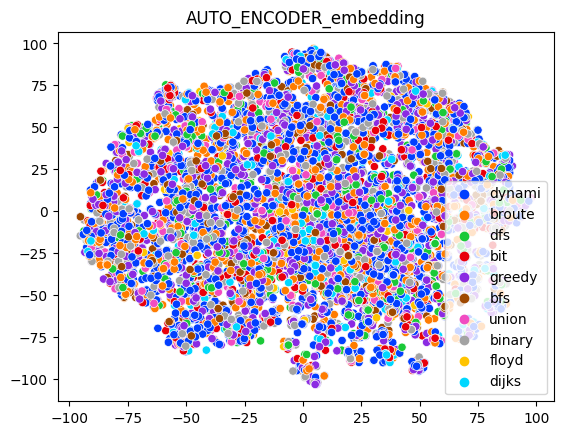

In [78]:
plt.title("AUTO_ENCODER_embedding")
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=ae_embedded[:,0], y=ae_embedded[:,1], hue=labels, legend='full', palette=palette)
plt.show()

In [ ]:
plt.title("EASE_embedding")
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=ae_embedded[:,0], y=ae_embedded[:,1], hue=labels, legend='full', palette=palette)
plt.show()